<a href="https://colab.research.google.com/github/kanakhan/GMSW/blob/main/stockpredictionwithlstmandarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf

data = yf.download("003480.KS", start="2020-03-01", end="2023-03-31")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


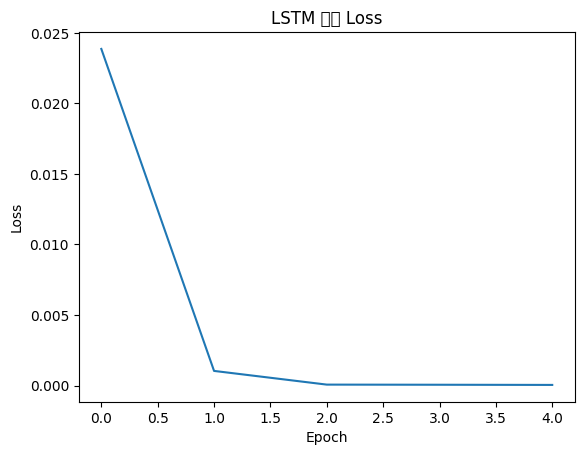

8/8 [==============================] - 0s 2ms/step
[*********************100%***********************]  1 of 1 completed
2/2 [==============================] - 0s 6ms/step
LSTM 모델의 MSE: 14847597.545459803


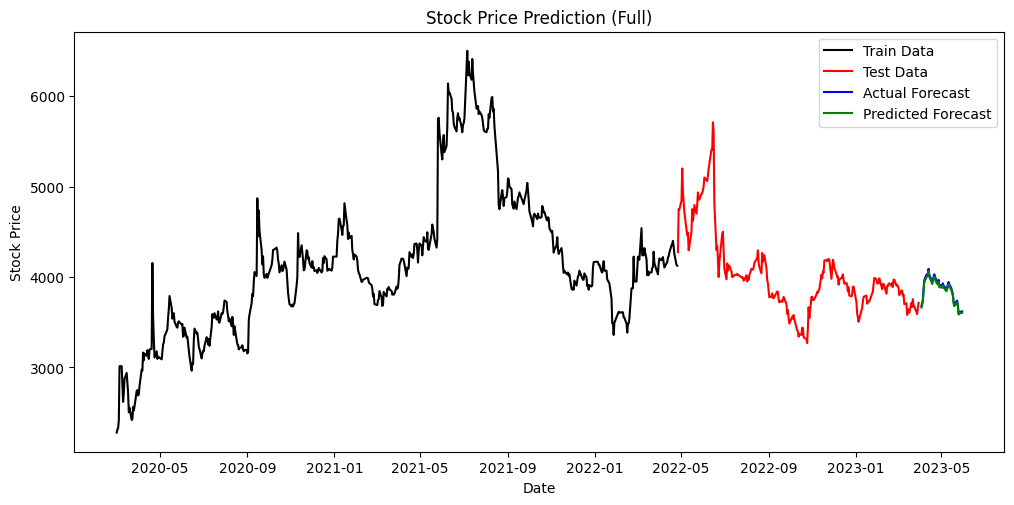

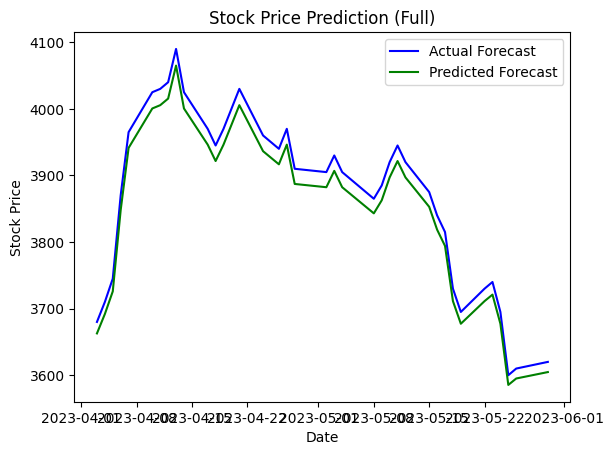

In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

#데이터 다운로드
stock_code = "003480.KS"
start_date = "2020-03-01"
end_date = "2023-03-31"

df = yf.download(stock_code, start=start_date, end=end_date)
df = df["Close"].reset_index()

#예외 처리: 데이터가 충분하지 않은 경우
if len(df) == 0:
    raise Exception("데이터가 충분하지 않습니다.")

#데이터 분할, 70%와 30%
train_size = int(len(df) * 0.7)
train_data = df[:train_size]
test_data = df[train_size:]

#예외 처리: 학습 데이터가 비어 있는 경우
if len(train_data) == 0:
    raise Exception("학습 데이터가 비어 있습니다.")

#LSTM 모델 구축
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data["Close"].values.reshape(-1, 1))

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

lstm_model = create_lstm_model()
history = lstm_model.fit(
    np.expand_dims(train_scaled, axis=1),
    train_scaled,
    epochs=5,
    batch_size=1,
    verbose=0
)

#Loss 그래프
plt.plot(history.history["loss"])
plt.title("LSTM 모델 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#LSTM 모델 예측
test_scaled = scaler.transform(test_data["Close"].values.reshape(-1, 1))
X_test = np.expand_dims(test_scaled, axis=1)
y_test = test_scaled

y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

#2023년 4월부터 2023년 5월까지 예측 및 평가
forecast_start_date = "2023-04-01"
forecast_end_date = "2023-05-31"

forecast_df = yf.download(stock_code, start=forecast_start_date, end=forecast_end_date)
forecast_actual = forecast_df["Close"].values

forecast_scaled = scaler.transform(forecast_actual.reshape(-1, 1))
X_forecast = np.expand_dims(forecast_scaled, axis=1)
y_forecast = forecast_scaled

y_forecast_pred = lstm_model.predict(X_forecast)
y_forecast_pred = scaler.inverse_transform(y_forecast_pred)

mse = mean_squared_error(y_forecast, y_forecast_pred)
print("LSTM 모델의 MSE:", mse)

#주가 예측 그래프 그리기
train_dates = train_data["Date"]
test_dates = test_data["Date"]
forecast_dates = forecast_df.index

plt.figure(figsize=(12, 12))

#전체 그래프
plt.subplot(2, 1, 1)
plt.plot(train_dates, train_data["Close"], color="black", label="Train Data")
plt.plot(test_dates, test_data["Close"], color="red", label="Test Data")
plt.plot(forecast_dates, forecast_actual, color="blue", label="Actual Forecast")
plt.plot(forecast_dates, y_forecast_pred, color="green", label="Predicted Forecast")
plt.title("Stock Price Prediction (Full)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

plt.plot(forecast_dates, forecast_actual, color="blue", label="Actual Forecast")
plt.plot(forecast_dates, y_forecast_pred, color="green", label="Predicted Forecast")
plt.title("Stock Price Prediction (Full)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()

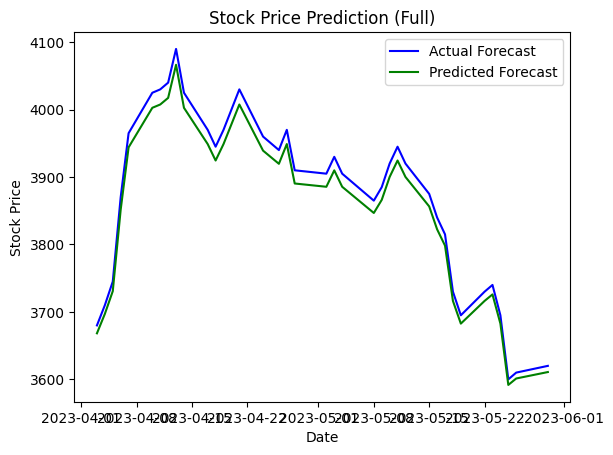

[*********************100%***********************]  1 of 1 completed


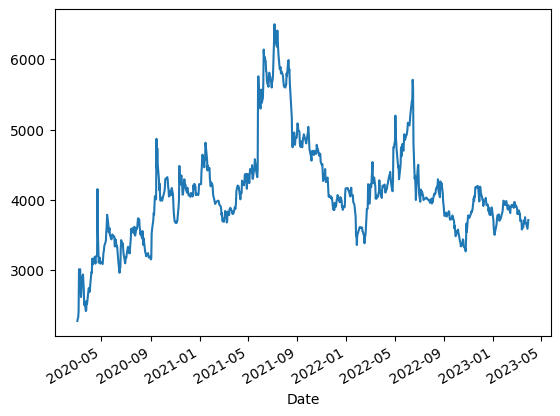

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  761
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4785.516
Date:                Wed, 07 Jun 2023   AIC                           9583.032
Time:                        17:41:47   BIC                           9610.832
Sample:                             0   HQIC                          9593.738
                                - 761                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0008      0.019      0.041      0.967      -0.037       0.039
ar.L2         -0.0186      0.027     -0.693      0.488      -0.071       0.034
ar.L3         -0.0360      0.027     -1.328      0.1

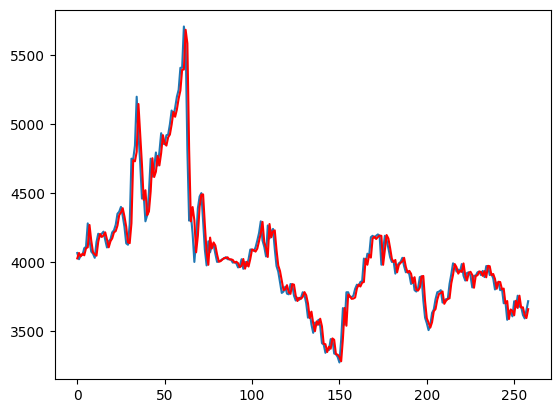

Test RMSE: 109.091


In [35]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Download historical data
data = yf.download("003480.KS", start="2020-03-01", end="2023-03-31")

# We will use 'Close' prices for our analysis
series = data['Close']

# Plot the time series data
series.plot()
plt.show()

# Fit the model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Predict prices
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0] # Update this line
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# Plot predicted vs actual values
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Print RMSE
error = mean_squared_error(test, predictions, squared=False) # Set squared=False for RMSE
print('Test RMSE: %.3f' % error)

[*********************100%***********************]  1 of 1 completed


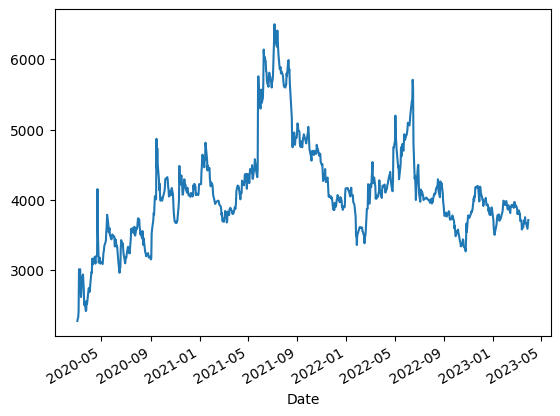

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  761
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4785.516
Date:                Wed, 07 Jun 2023   AIC                           9583.032
Time:                        17:46:07   BIC                           9610.832
Sample:                             0   HQIC                          9593.738
                                - 761                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0008      0.019      0.041      0.967      -0.037       0.039
ar.L2         -0.0186      0.027     -0.693      0.488      -0.071       0.034
ar.L3         -0.0360      0.027     -1.328      0.1

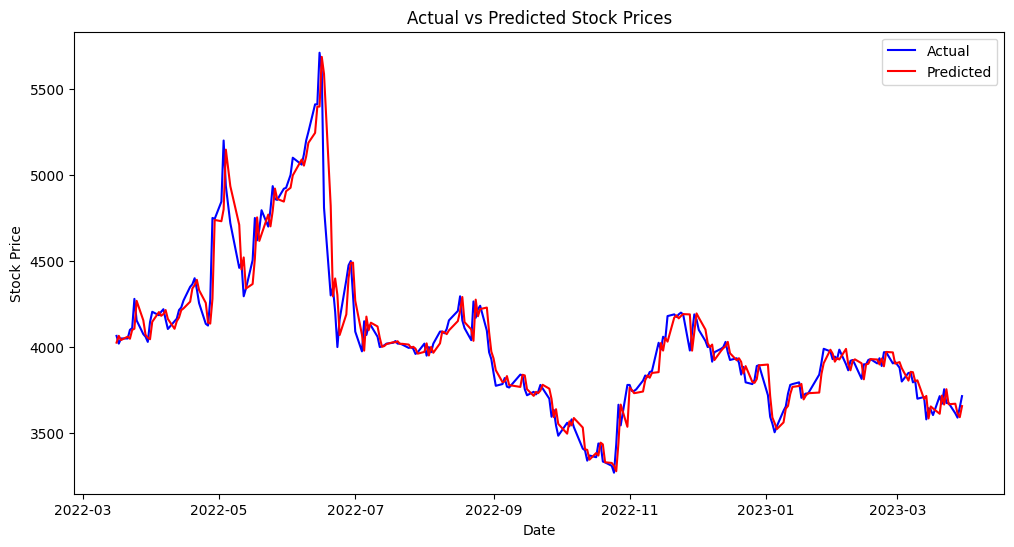

Test RMSE: 109.091


In [36]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Download historical data
data = yf.download("003480.KS", start="2020-03-01", end="2023-03-31")

# We will use 'Close' prices for our analysis
series = data['Close']

# Plot the time series data
series.plot()
plt.show()

# Fit the model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Predict prices
size = int(len(series) * 0.66)
train, test = series[0:size], series[size:len(series)] # Keep as Series to preserve date index
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# Create a time index for the predictions
pred_index = series.index[size:len(series)] 

# Plot predicted vs actual values
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(pred_index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Print RMSE
error = mean_squared_error(test, predictions, squared=False) # Set squared=False for RMSE
print('Test RMSE: %.3f' % error)

In [38]:
!pip install pymc3

import pymc3 as pm
import pandas as pd
import yfinance as yf
import numpy as np

# Download historical data
data = yf.download("003480.KS", start="2020-03-01", end="2023-03-31")

# We will use 'Close' prices for our analysis
returns = data['Close'].pct_change()

returns = returns.dropna() * 100

# Define model
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=10)
    returns_obs = pm.Normal('returns_obs', mu=mu, sd=sigma, observed=returns)

# Perform MCMC
with model:
    trace = pm.sample(2000)

pm.plot_trace(trace)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 94.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.0 MB/s eta 0:00:0

RuntimeError: ignored